In [1]:
from manim import *
import cv2
import numpy as np
import dlib  # type: ignore

def extract_frames_and_faces() -> tuple[list[np.ndarray], list[np.ndarray]]:
    SAMPLE = "./../assets/sample.mp4"
    face_detector = dlib.get_frontal_face_detector()
    # Open the video
    cap = cv2.VideoCapture(SAMPLE)
    frames, face_crops = [], []
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    # Frame index counter
    frame_idx = 0

    # Read frames from the video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        faces = face_detector(frame)
        face = None
        for face_rect in faces:
            x, y, w, h = (
                face_rect.left(),
                face_rect.top(),
                face_rect.width(),
                face_rect.height(),
            )
            face = frame.copy()[y : y + h, x : x + w]

            color = (0, 255, 0)  # Green color in RGB
            thickness = 2

            cv2.rectangle(frame, (x, y), (x + w, y + h), color, thickness)
            break  # We decided to keep only one face in case more where present.
        if face is None:
            break
        face_crops.append(face)
        frames.append(frame)

        frame_idx += 1

        # Break the loop if we have processed frame 29
        if frame_idx > 29:
            break

    # Release everything
    cap.release()

    return frames, face_crops


In [2]:
%%manim -ql -v WARNING  --progress_bar None DisplayVideo
from manim import Scene, ImageMobject, Transform  # type: ignore

# This is the Jupyter magic command to render Manim animations inline

class DisplayVideo(Scene):
    def construct(self):

        frames, face_crops = extract_frames_and_faces()

        # Duration each frame is displayed
        frame_duration = 1 / 24  # Assuming 24 FPS for the video playback

        for i, frame in enumerate(frames):
            last_frame = ImageMobject(frame)
            last_frame.scale_to_fit_height(
                self.camera.frame_height
            ) 
            if i == 0:
                continue

            # Load the frame
            frame = ImageMobject(frame)
            frame.scale_to_fit_height(
                self.camera.frame_height
            )  # Scale to fit the scene

            # Play each frame
            if i == 0:
                self.add(frame)  # Add the first frame without animation
            else:
                self.play(Transform(last_frame, frame), run_time=frame_duration)

            # Update the last frame to the current frame

        self.wait(0.1)  # Wait a little at the end

Manim Community v0.18.1

Manim Community v0.18.1

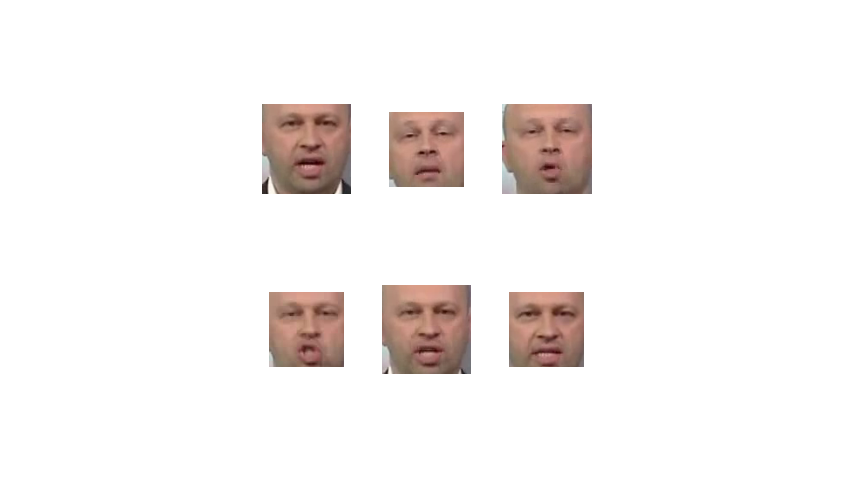

In [3]:
%%manim -ql -v ERROR --progress_bar None VideoToFacesTransition

from manim import *

class VideoToFacesTransition(Scene):
    def construct(self):
        self.camera.background_color = WHITE
        # Assuming `extract_frames_and_faces()` provides a list of face crops
        _, face_crops = extract_frames_and_faces()
        
        # Create dictionary to store face crops by their shapes
        face_crops_dict = {face_crop.shape: face_crop for face_crop in face_crops}

        # Create ImageMobjects from face crops
        face_frames = [ImageMobject(face_crop) for face_crop in face_crops_dict.values()]

        # Define grid parameters
        grid_cols = 3
        grid_rows = 2
        grid_width = 4
        grid_height = 3
        
        # Calculate the maximum width and height for a single cell in the grid
        max_cell_width = grid_width / grid_cols
        max_cell_height = grid_height / grid_rows

        # Find the largest original width and height among all frames
        max_original_width = max(frame.width for frame in face_frames)
        max_original_height = max(frame.height for frame in face_frames)

        # Determine the scaling factor to fit the largest frame within a single grid cell
        scaling_factor = max(max_cell_width / max_original_width, max_cell_height / max_original_height)

        # Apply the constant scaling factor to all frames
        for frame in face_frames:
            frame.scale(scaling_factor)

        # Calculate spacing
        x_spacing = grid_width / (grid_cols - 1)
        y_spacing = grid_height / (grid_rows - 1)

        # Position face frames in the grid
        for i, frame in enumerate(face_frames):
            col = i % grid_cols
            row = i // grid_cols
            
            # Calculate the position
            x_position = -grid_width / 2 + col * x_spacing
            y_position = grid_height / 2 - row * y_spacing
            
            # Set frame position
            frame.move_to([x_position, y_position, 0])

            # Add frame to the scene
            self.add(frame)




In [4]:
# Helper functions for padding
def pad_to_max_dimensions(frames: list[np.ndarray], max_height: int, max_width: int) -> list[np.ndarray]:
    """
    Pads the frames in the list to match the maximum height and width.

    Args:
        frames (list[np.ndarray]): A list of NumPy arrays representing frames.
        max_height (int): The maximum height to pad the frames to.
        max_width (int): The maximum width to pad the frames to.

    Returns:
        list[np.ndarray]: A list of NumPy arrays with padded frames.
    """
    padded_frames = []
    
    for frame in frames:
        height, width = frame.shape[:2]
        
        pad_height = max_height - height
        pad_width = max_width - width
        # Calculate the padding amounts
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        
        # Pad the frame using constant padding with value 0
        padded_frame = np.pad(
            frame,
            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),  # Pad height, width, and channels
            mode='constant',
            constant_values=0
        )
        
        padded_frames.append(padded_frame)
    
    return padded_frames

In [5]:
%%manim -ql -v ERROR --progress_bar None PaddingMorph

class PaddingMorph(Scene):
    def construct(self):
        self.camera.background_color = WHITE
        
        # Assuming `extract_frames_and_faces()` provides a list of face crops
        _, face_crops = extract_frames_and_faces()
        
        # Create dictionary to store face crops by their shapes
        face_crops_dict = {face_crop.shape: face_crop for face_crop in face_crops}

        # Create ImageMobjects from face crops
        face_frames = [ImageMobject(face_crop) for face_crop in face_crops_dict.values()]

        # Define grid parameters
        grid_cols = 3
        grid_rows = 2
        grid_width = 4
        grid_height = 3
        
        # Calculate the maximum width and height for a single cell in the grid
        max_cell_width = grid_width / grid_cols
        max_cell_height = grid_height / grid_rows

        # Find the largest original width and height among all frames
        max_original_width = max(frame.width for frame in face_frames)
        max_original_height = max(frame.height for frame in face_frames)

        # Determine the scaling factor to fit the largest frame within a single grid cell
        scaling_factor = max(max_cell_width / max_original_width, max_cell_height / max_original_height)

        # Apply the constant scaling factor to all frames
        for frame in face_frames:
            frame.scale(scaling_factor)

        # Calculate spacing
        x_spacing = grid_width / (grid_cols - 1)
        y_spacing = grid_height / (grid_rows - 1)

        # Position face frames in the grid
        for i, frame in enumerate(face_frames):
            col = i % grid_cols
            row = i // grid_cols
            
            # Calculate the position
            x_position = -grid_width / 2 + col * x_spacing
            y_position = grid_height / 2 - row * y_spacing
            
            # Set frame position
            frame.move_to([x_position, y_position, 0])

            # Add frame to the scene
            self.add(frame)

        self.wait(1)

        # Compute padding for frames to maximum dimensions
        max_height = max(frame.shape[0] for frame in face_crops)
        max_width = max(frame.shape[1] for frame in face_crops)
        padded_face_crops = pad_to_max_dimensions(face_crops_dict.values(), max_height, max_width)

        # Create ImageMobjects for padded frames
        padded_face_frames = [ImageMobject(padded_crop) for padded_crop in padded_face_crops]
         # Apply the constant scaling factor to all frames
        for frame in padded_face_frames:
            frame.scale(scaling_factor)

        # Position padded frames in the same grid positions
        for i, frame in enumerate(padded_face_frames):
            col = i % grid_cols
            row = i // grid_cols
            
            # Calculate the position
            x_position = -grid_width / 2 + col * x_spacing
            y_position = grid_height / 2 - row * y_spacing
            
            # Set frame position
            frame.move_to([x_position, y_position, 0])
            # Add frame to the scene
            self.add(frame)

        # Animate the morphing from original to padded frames using CrossFade
        animations = []
        for original_frame, padded_frame in zip(face_frames, padded_face_frames):
            # Ensure that both frames start at the same position
            padded_frame.move_to(original_frame.get_center())
            padded_frame.set_opacity(0)  # Start with padded frame invisible

            # Add both frames to the scene
            self.add(padded_frame)

            # Create crossfade animation
            fade_out = original_frame.animate.set_opacity(0)
            fade_in = padded_frame.animate.set_opacity(1)
            crossfade = AnimationGroup(fade_out, fade_in, lag_ratio=0)
            animations.append(crossfade)

        # Play the animations
        self.play(*animations, run_time=2)

        # Wait to display the final scene
        self.wait(1)

Manim Community v0.18.1

In [83]:
%%manim -ql -v ERROR --progress_bar None PaddingMorphToStack


class PaddingMorphToStack(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE
        
        # Simulate the extraction of face images as numpy arrays 
        _, face_crops = extract_frames_and_faces()  

        # Create dictionary to store face crops by their shapes
        face_crops_dict = {face_crop.shape: face_crop for face_crop in face_crops}
        
        # Pad the images
        max_height = max(crop.shape[0] for crop in face_crops)
        max_width = max(crop.shape[1] for crop in face_crops)
        padded_images = pad_to_max_dimensions(face_crops_dict.values(), max_height, max_width)

        # Create ImageMobjects
        padded_face_frames = [ImageMobject(padded_image) for padded_image in padded_images]
        
        # Setup grid
        grid_cols = 3
        grid_rows = 2
        grid_width = 4
        grid_height = 3

        max_cell_width = grid_width / grid_cols
        max_cell_height = grid_height / grid_rows

        # Find the largest original width and height among all frames
        max_original_width = max(frame.width for frame in padded_face_frames)
        max_original_height = max(frame.height for frame in padded_face_frames)

        # Determine the scaling factor to fit the largest frame within a single grid cell
        scaling_factor = max(max_cell_width / max_original_width, max_cell_height / max_original_height)

        # Calculate spacing
        x_spacing = grid_width / (grid_cols - 1)
        y_spacing = grid_height / (grid_rows - 1)

        for i, frame in enumerate(padded_face_frames):
            frame.scale(scaling_factor)
            col = i % grid_cols
            row = i // grid_cols
            
            # Calculate the position
            x_position = -grid_width / 3 + col * x_spacing
            y_position = grid_height / 2 - row * y_spacing
            
            # Set frame position
            frame.move_to([x_position, y_position, 0])
            # Add frame to the scene
            self.add(frame)
            

        # Stak frames togheter
        for i, frame in enumerate(padded_face_frames[::-1]):
            # Move frames to be centered in view
            new_position = np.array([0, 0, i * 0.5])  # Adjust Z-position for 3D effect
            self.play(frame.animate.move_to(new_position), run_time=1)

        
        # Create the frames (assuming placeholders here)
        padded_face_frames = [frame for frame in padded_face_frames]  # Use Square as a placeholder
        frame_group = Group(*padded_face_frames)
        
        # Position the group at the center initially
        frame_group.move_to(ORIGIN)
        self.add(frame_group)
        self.wait(1)

        # Animate the group
        # Rotate the group around its center, azimuthal rotation (around the Y-axis)
        self.play(Rotate(frame_group, angle=-PI/4, axis=UP, about_point=ORIGIN), run_time=1)
        
        self.wait(1)


Manim Community v0.18.1